# Estimation of the parameters of the Ivanov model for the individuals

The goal of this notebook is find the best fit of the feedback input strengths $w_{SA}, w_{SS}, w_{PS}$ parameters of the Ivanov model for each subject using the maximum likelihood estimation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import time

from scipy import signal
from numpy import random
from scipy.stats import norm
from scipy.stats import laplace
from scipy.optimize import minimize

import sys
sys.path.append('../')
import FractalModels as fm
import FractalAnalysis as fa

## Maximum Likelihood estimation with one feedback input
The maximum likelihood estimation will be done in several steps. We will first estimate one parameter at the time by removing the other feedback inputs of the Ivanov model.

In [2]:
def signal_to_data(sig):
    """
    Transform a heart rate signal into a more usable form for the likelihood estimation.
    The data is transformed into a list of lists of size 2. The first element is the difference
    between interbeats n and n-1. The second one is the interbeat n-1.

    Arguments:
    - sig: the heart rate signal

    Returns:
    - the list of transformed signal
    """

    data = []

    for i in range(len(sig)-1):
        x1 = sig[i+1] - sig[i]
        x2 = sig[i]
        final_x = [x1, x2]
        data.append(final_x)

    return data

def plot_min(x, results):
    """
    Plots a curve and highlight the minimum of that curve

    Arguments:
    - x: the x values of the curve
    - results: the y values of the curve
    """

    n_min = np.argmin(results)
    print(x[n_min])

    plt.plot(x, results)
    plt.plot(x[n_min], results[n_min], 'o')
    plt.show()

def histogram_plot(results, title):
    """
    Plots the histogram of results

    Arguments:
    - results: the results to be plotted
    - title: the title of the plot
    """

    fig, axis = plt.subplots(figsize = (10, 5))
    axis.hist(results,  color="lightblue", ec="black", bins=20)
    plt.title(title)
    plt.xlabel("Precision")
    plt.ylabel("Number of signals")
    plt.show()

### SA node

In [3]:
def SA_proba(t_n, mean_eta=0, std_eta=0.5*math.sqrt(2), t_SA=0.6, w_SA=0.01):
    """
    Compute the probability distribution of the input SA based on the
    previous interbeat.

    Arguments:
    - t_n: the previous interbeat
    - mean_eta: mean of the white noise of the Ivanov model
    - std_eta: standard deviation of the noise of the Ivanov model
    - t_SA: the preferred level of SA of the Ivanov model
    - w_SA: the input strength of SA in the Ivanov model

    Returns:
    - the mean of the distribution
    - the standard deviation of the distribution
    """
    mean = mean_eta*w_SA + w_SA
    std = std_eta*w_SA
        
    if t_n >= t_SA:
        mean *= -1
        
    return mean, std



def likelihood_SA(params, x):
    """
    Compute the likelihood of a signal based on the value of w_SA. It is assumed
    that only I_SA has impact on the interbeat at time n in the Ivanov model

    Arguments:
    - params: the parameter value of w_SA
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    likelihood = 0
    for el in x:
        mean, std = SA_proba(el[1], w_SA=params[0])
        l1 = laplace.pdf(el[0], loc=mean, scale=std/math.sqrt(2))
        if l1 == 0:
            l1 = 1e-20
        likelihood += np.log(l1)

    return -likelihood

#### Parameter estimation on one trial

In [11]:
# Perform maximum likelihood estimation with minimize

sig = fm.IvanovModel(w_SS=0, w_PS=0, w_SA=0.01, Num_beats=5000, std_T=1, std_eta=0.5*math.sqrt(2))

data = signal_to_data(sig)
                
bds = [(1e-06, 1)]
init_params = [random.uniform(0, 1)]
result = minimize(likelihood_SA, init_params, args=(data,), bounds = bds) #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
print(result.x[0])

0.01006332353251082


0.0890909090909091


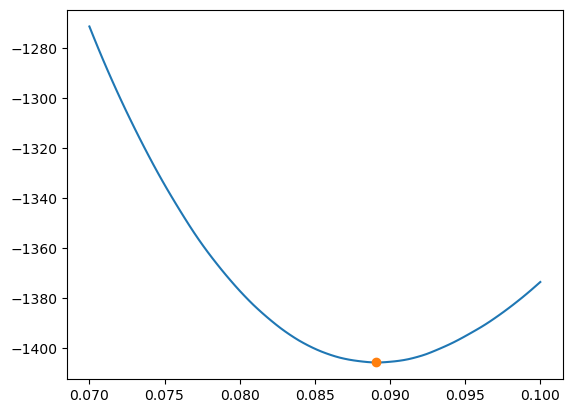

In [9]:
# Prints the minimum for the likelihood over w_SA

w_SA_s = np.linspace(0.07, 0.1, 100)

sig = fm.IvanovModel(w_SS=0, w_PS=0, w_SA=0.09, Num_beats=1000, mean_T=1, std_T=1)

data = signal_to_data(sig)

results = []

for w_SA in w_SA_s:
    init_params = [w_SA]
    likelihood = likelihood_SA(init_params, data)
    results.append(likelihood)

plot_min(w_SA_s, results)

#### MLE on several trials

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [4:46:29<00:00, 34.38s/it]


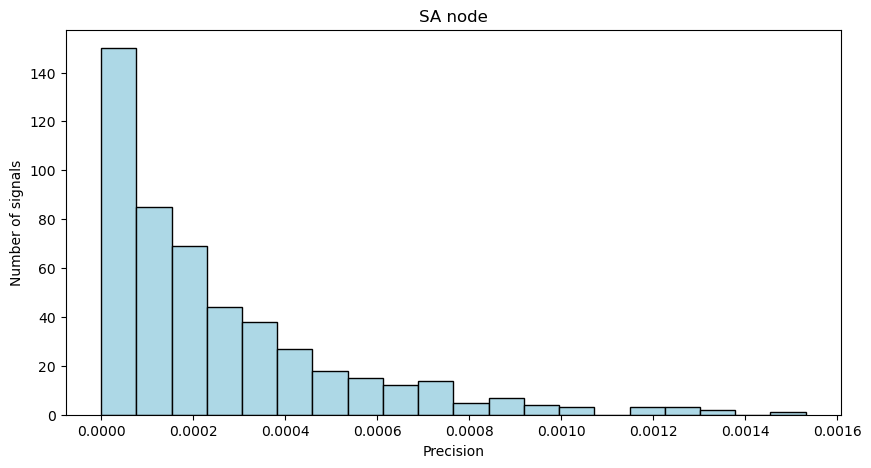

In [4]:
results = []

for i in tqdm(range(500)):

    w_SA = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SS=0, w_PS=0, w_SA=w_SA, Num_beats=5000, N=0, std_eta=0.5*math.sqrt(2), mean_T=1, std_T=1)

    data = signal_to_data(sig)
                
    bds = [(1e-06, 1)]
    init_params = [random.uniform(0, 1)]
    result = minimize(likelihood_SA, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_SA)
    results.append(precision)

histogram_plot(results, "SA node")

### Parasympathetic system

In [5]:
def PS_proba(t_n, mean_eta=0, std_eta=0.5*math.sqrt(2),t_lower=0.9, t_higher=1.5, w=0.03):
    """
    Compute the probability distribution of the input PS based on the
    previous interbeat.

    Arguments:
    - t_n: the previous interbeat
    - mean_eta: mean of the white noise of the Ivanov model
    - std_eta: standard deviation of the noise of the Ivanov model
    - t_lower: lower bound for the preferred level of PS of the Ivanov model
    - t_higher: higher bound for the preferred level of PS of the Ivanov model
    - w: the input strength of PS in the Ivanov model

    Returns:
    - True if the distribution is unimodal
    - the mean of the distribution
    - the standard deviation of the distribution
    - the probability that t_n is lower than the preferred level
    """

    mean = w
    std = std_eta*w
    is_normal = True
    p_t = 0
    
    if t_n >= t_higher:
        mean *= -1
            
    elif t_n > t_lower:
        p_t = (t_n - t_lower)/(t_higher - t_lower)
        is_normal = False
                
        
    return is_normal, mean, std, p_t




def likelihood_PS(params, x):
    """
    Compute the likelihood of a signal based on the value of w_PS. It is assumed
    that only I_PS has impact on the interbeat at time n in the Ivanov model

    Arguments:
    - params: the parameter value of w_PS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    likelihood = 0
    for el in x:
        is_normal, mean, std, p_t = PS_proba(el[1], w=params[0])
        if is_normal:
            l1 = laplace.pdf(el[0], loc=mean, scale=std/math.sqrt(2))
        else:
            l1 = p_t*laplace.pdf(el[0], loc=-mean, scale=std/math.sqrt(2)) + (1-p_t)*laplace.pdf(el[0], loc=mean, scale=std/math.sqrt(2))

        if l1 == 0:
            l1 = 1e-20
        likelihood += np.log(l1)

    return -likelihood


#### MLE on one trial

In [94]:
sig = fm.IvanovModel(w_SS=0, w_PS=0.03, w_SA=0, Num_beats=1000, std_T=1)

data = signal_to_data(sig)
                
bds = [(1e-06, 1)]
init_params = [random.uniform(0, 1)]
result = minimize(likelihood_PS, init_params, args=(data,), bounds = bds) #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
print(result.x[0])

0.03479410304226766


100%|██████████| 100/100 [00:08<00:00, 12.01it/s]

0.03666666666666667


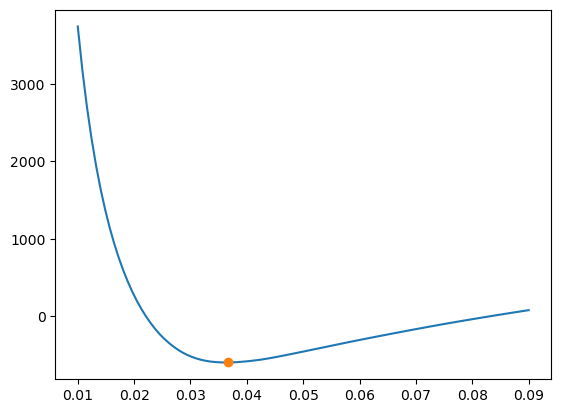

In [15]:
w_PS_s = np.linspace(0.01, 0.09, 100)

sig = fm.IvanovModel(w_SS=0, w_PS=0.03, w_SA=0, Num_beats=1000, std_T=1, mean_T=1)

data = signal_to_data(sig)

results = []

for w_PS in tqdm(w_PS_s):

    init_params = [w_PS]
    likelihood = likelihood_PS(init_params, data)
    results.append(likelihood)

plot_min(w_PS_s, results)

#### MLE on several trials

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [9:00:06<00:00, 64.81s/it]


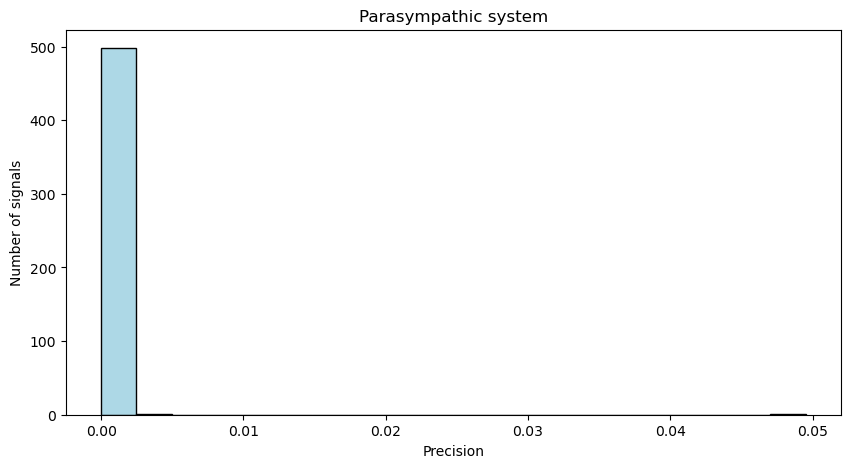

In [29]:
results = []

for i in tqdm(range(500)):

    w_PS = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SS=0, w_PS=w_PS, w_SA=0, Num_beats=5000, N=0, std_eta=0.5*math.sqrt(2))

    data = signal_to_data(sig)
                
    bds = [(1e-06, 1)]
    init_params = [random.uniform(0, 1)]
    result = minimize(likelihood_PS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_PS)
    results.append(precision)

histogram_plot(results, "Parasympathic system")
PS_results = results

499
500


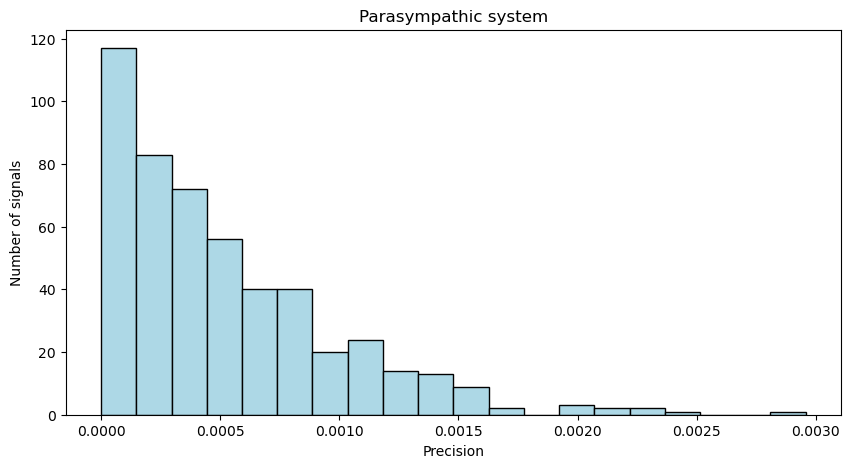

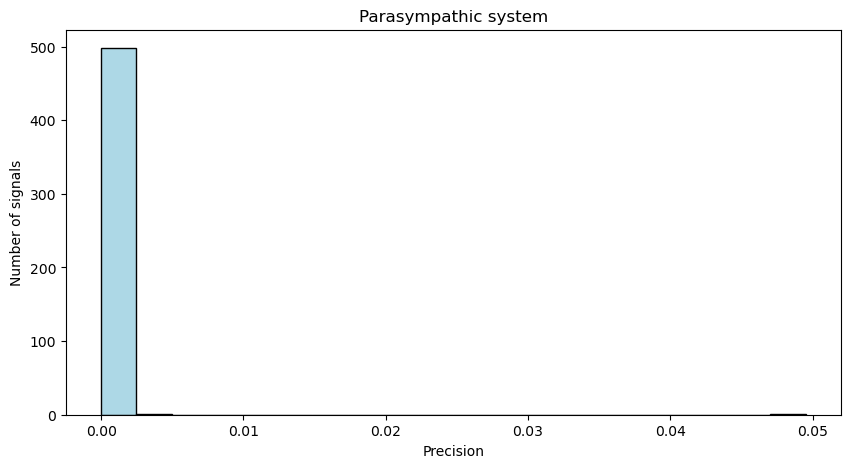

In [32]:
test_results_PS = [x for x in PS_results if x <= 0.02]
print(len(test_results_PS))
print(len(results))
histogram_plot(test_results_PS, "Parasympathic system")
histogram_plot(PS_results, "Parasympathic system")

### Sympathetic systems

In [7]:
def SS_proba_N(t_n, std_eta=0.5*math.sqrt(2),t_lower=0.2, t_higher=1, w=0.01, N=7):
    """
    Compute the probability distribution of the feedback input SS based on the
    previous interbeat. This method computes the probability of the sum of all
    inputs by considering this sum follows a normal distribution.

    Arguments:
    - t_n: the previous interbeat
    - mean_eta: mean of the white noise of the Ivanov model
    - std_eta: standard deviation of the noise of the Ivanov model
    - t_lower: lower bound for the preferred level of SS of the Ivanov model
    - t_higher: higher bound for the preferred level of SS of the Ivanov model
    - w: the input strength of SS in the Ivanov model
    - N: the number of inputs

    Returns:
    - the mean of the distribution
    - the standard deviation of the distribution
    """
    mean = w
    std = std_eta*w
    p_t = 0
    
    if t_n >= t_higher:
        mean *= -1
            
    elif t_n > t_lower:
        p_t = (t_n - t_lower)/(t_higher - t_lower)
        var = mean**2 + std**2 - ((-2*p_t+1) * mean)**2
        std = math.sqrt(var)
        mean = p_t*(-1*mean) + (1 - p_t)*(mean)

    mean *= N
    std *= math.sqrt(N)
                
        
    return mean, std

def likelihood_SS_normal(params, x):
    """
    Compute the likelihood of a signal based on the value of w_SS. It is assumed
    that only I_SS has impact on the interbeat at time n in the Ivanov model. This
    assumes that the sum of all inputs follows a normal ditribution.

    Arguments:
    - params: the parameter value of w_SS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    likelihood = 0
    for el in x:
        mean, std = SS_proba_N(el[1], w=params[0], N=7)
        l1 = norm.pdf(el[0], loc=mean, scale=std)
        if l1 == 0:
            l1 = 1e-20
        likelihood += np.log(l1)

    return -likelihood


def SS_proba(t_n, std_eta=0.5,t_lower=0.2, t_higher=1, w=0.01):
    """
    Compute the probability distribution of the feedback input of SS based on the
    previous interbeat. This method computes the probability of one input.

    Arguments:
    - t_n: the previous interbeat
    - mean_eta: mean of the white noise of the Ivanov model
    - std_eta: standard deviation of the noise of the Ivanov model
    - t_lower: lower bound for the preferred level of SS of the Ivanov model
    - t_higher: higher bound for the preferred level of SS of the Ivanov model
    - w: the input strength of SS in the Ivanov model
    - N: the number of inputs feedback

    Returns:
    - the mean of the distribution
    - the standard deviation of the distribution
    """
    mean = w
    std = std_eta*w
    is_unimodal = True
    p_t = 0
    
    if t_n >= t_higher:
        mean *= -1
            
    elif t_n > t_lower:
        p_t = (t_n - t_lower)/(t_higher - t_lower)
        is_unimodal = False
                        
        
    return mean, std, is_unimodal, p_t

def likelihood_SS(params, x):
    """
    Compute the likelihood of a signal based on the value of w_SS. It is assumed
    that only I_SS has impact on the interbeat at time n in the Ivanov model

    Arguments:
    - params: the parameter value of w_SS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    likelihood = 0
    for el in x:
        mean, std, is_unimodal, p_t = SS_proba(el[1], w=params[0])
        limit = (abs(mean) + 3*std)*7
        x_tmp = np.arange(-limit, limit, 0.0001)

        if is_unimodal:
            y = conv = laplace.pdf(x_tmp, mean, std/math.sqrt(2))
        else: 
            y = conv = p_t * laplace.pdf(x_tmp, -1*mean, std/math.sqrt(2)) + (1 - p_t) * laplace.pdf(x_tmp, mean, std/math.sqrt(2))

        for i in range(7):
            conv = signal.fftconvolve(y, conv, mode='same') * 0.0001

        l1 = np.interp(el[0], x_tmp, conv)
        if l1 <= 0:
            l1 = 1e-20
        likelihood += np.log(l1)

    return -likelihood

#### MLE on one trial

In [ ]:
w_SS_s = np.linspace(0.001, 0.1, 50)

t_SA = random.uniform(0.2, 1)

sig = fm.IvanovModel(w_SS=0.01, w_PS=0, w_SA=0, t_SA=t_SA, Num_beats=5000, N=7, std_eta=0.5*math.sqrt(2))

data = signal_to_data(sig)

results = []

for w_SS in tqdm(w_SS_s):

    init_params = [w_SS]
    likelihood = likelihood_SS_normal(init_params, data)
    results.append(likelihood)

plt.plot(w_SS_s, results)
n_min = np.argmin(results)
plt.plot(w_SS_s[n_min], results[n_min], 'o')
plt.show()

print(w_SS_s[n_min])

#### MLE on several trials

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [4:58:44<00:00, 35.85s/it]


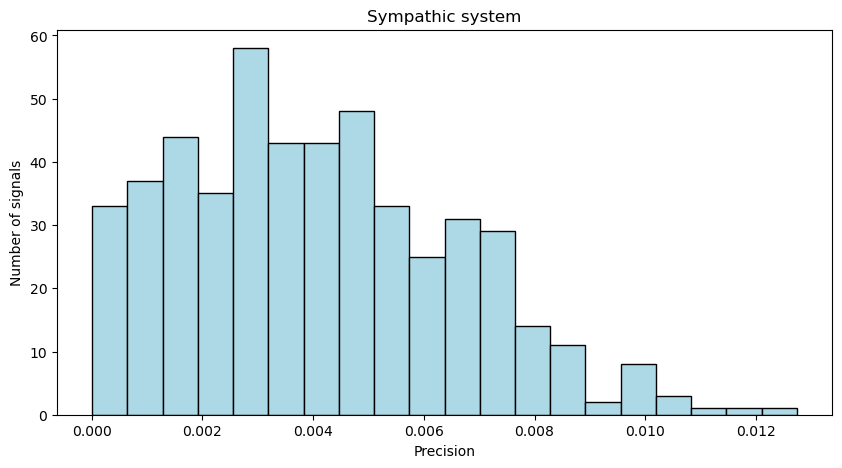

In [11]:
results = []

for i in tqdm(range(500)):

    w_SS = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SS=w_SS, w_PS=0, w_SA=0, Num_beats=5000)

    data = signal_to_data(sig)
                
    bds = [(1e-06, 1)]
    init_params = [random.uniform(0, 1)]
    result = minimize(likelihood_SS_normal, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_SS)
    results.append(precision)

histogram_plot(results, "Sympathic system")

500
500


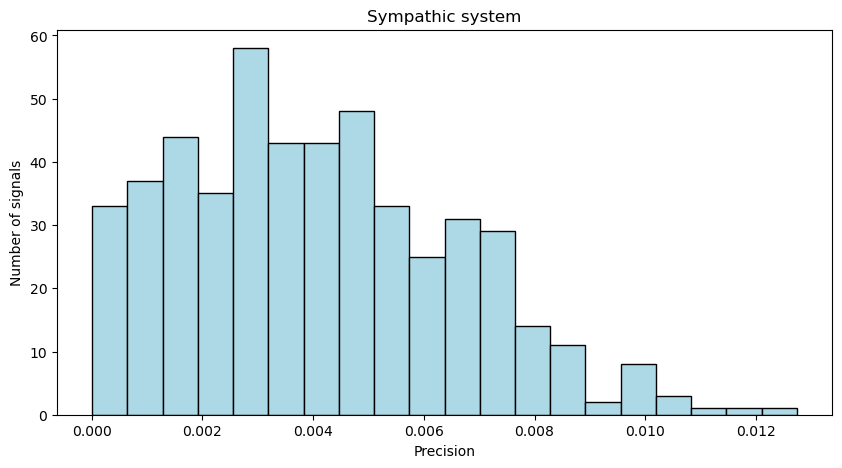

In [12]:
test_results = results
test_results = [x for x in results if x <= 0.02]
print(len(test_results))
print(len(results))
histogram_plot(test_results, "Sympathic system")

## Maximum likelihood estimation with two feedback  inputs
The principle is the same than in the previous section, but this time, we consider that the Ivanov model has two feedback inputs.

In [ ]:
def get_limit(mean1, mean2, std1, std2, unimodal):
    """
    Computes the bounds at which it can considered that the probability of the sum of two random
    variables will be 0

    Arguments:
    - mean1: the mean of the distribution of the first random variable
    - mean1: the mean of the distribution of the second random variable
    - std1: the standard deviation of the distribution of the first random variable
    - std2: the standard deviation of the distribution of the second random variable
    - unimodel: 1 if the first random variable has an unimodal distribution, -1 otherwise

    Returns:
    - the limit (the distribution will be computed between -limit and limit)
    """

    min1 = unimodal*mean1 - 3*std1 # Unimodal = 1 if is unimodal, -1 otherwise
    min2 = -mean2 - 3*std2
    min_both = min2 + min1
    final_min = min(min1, min2, min_both)

    max1 = mean1 + 3*std1
    max2 = mean2 + 3*std2
    max_both = max2 + max1
    final_max = max(max1, max2, max_both)

    if final_min<0:
        limit = max(final_max, -final_min)
    else:
        limit = final_max

    return limit


def plot_3d(x, y, z, title="", xlabel="", ylabel="", zlabel="", angle1=30, angle2=30):
    """
    Plots a 3D plot

    Arguments:
    - x: the x values to be plotted
    - y: the y values to be plotted
    - z: the z values to be plotted
    - title: the title of the plot
    - xlabel: the x label of the plot
    - ylabel: the y label of the plot
    - zlabel: the z label of the plot
    - angle1: the first angle of the plot
    - angle2: the second angle of the plot
    """

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(np.asarray(x), np.asarray(y))
    ax.plot_wireframe(X, Y, np.asarray(z), color='black')
    ax.plot_surface(X, Y, np.asarray(z), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.view_init(angle1, angle2)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    plt.show()

### Mixing SA and PS

In [14]:
def likelihood_SA_PS(params, x):
    """
    Compute the likelihood of a signal based on the value of w_SA and w_PS. 
    It is assumed that only I_SA and I_PS has impact on the interbeat at 
    time n in the Ivanov model.

    Arguments:
    - params: the parameter value of w_SA and w_PS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """

    neg_log_likelihood = 0
    for el in x:
        mean_SA, std_SA = SA_proba(el[1], w_SA=params[0], std_eta=0.5 * math.sqrt(2))
        is_unimodal, mean_PS, std_PS, p_t = PS_proba(el[1], w=params[1], std_eta=0.5 * math.sqrt(2))

        # Unimodal distribution for PS
        if is_unimodal:
            mean = mean_SA + mean_PS
            std = math.sqrt(std_SA**2 + std_PS**2)
            likelihood = laplace.pdf(el[0], loc=mean, scale=std/math.sqrt(2))

        # Bimodal distribution for PS
        else:
            limit = get_limit(mean_SA, mean_PS, std_SA, std_PS, 1)

            precision = 0.0001
            x_tmp = np.arange(-limit, limit, precision)
            pdf_SA = laplace.pdf(x_tmp, loc=mean_SA, scale=std_SA/math.sqrt(2))
            pdf_PS = p_t*laplace.pdf(x_tmp, loc=-mean_PS, scale=std_PS/math.sqrt(2)) + (1-p_t)*laplace.pdf(x_tmp, loc=mean_PS, scale=std_PS/math.sqrt(2))
            pdf = signal.convolve(pdf_SA, pdf_PS, mode='same') * precision

            likelihood = np.interp(el[0], x_tmp, pdf)

        if likelihood<=0:
            likelihood = 1e-20
        
        neg_log_likelihood -= np.log(likelihood)

    return neg_log_likelihood


#### MLE on one trial

In [104]:
w_SA_s = np.linspace(0.005, 0.1, 20)
w_PS_s = np.linspace(0.005, 0.1, 20)

likelihoods = []

sig = fm.IvanovModel(w_SA=0.01, w_PS=0.03, w_SS=0, Num_beats=1000, std_eta=0.5*math.sqrt(2))

data = signal_to_data(sig)

for w_SA in tqdm(w_SA_s):
    tmp = []
    for w_PS in w_PS_s:

        params = [w_SA, w_PS]
        x = likelihood_SA_PS(params, data)
        tmp.append(x)

    likelihoods.append(tmp)


100%|██████████| 20/20 [06:14<00:00, 18.71s/it]


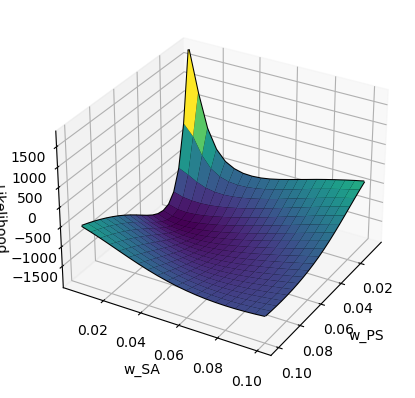

In [105]:
plot_3d(w_SA_s, w_PS_s, likelihoods, xlabel="w_PS", ylabel="w_SA", zlabel="Likelihood", angle1=30, angle2=30)

In [106]:
sig = fm.IvanovModel(w_SS=0, w_PS=0.03, w_SA=0.01, Num_beats=1000, std_eta=0.5*math.sqrt(2), mean_T=1, std_T=1)

data = signal_to_data(sig)
                
bds = [(1e-06, 0.5), (1e-06, 0.5)]
init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5)]
result = minimize(likelihood_SA_PS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
print(result.x)

[0.00974874 0.02935199]


#### MLE on several trials

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [1:50:08<00:00, 132.17s/it]


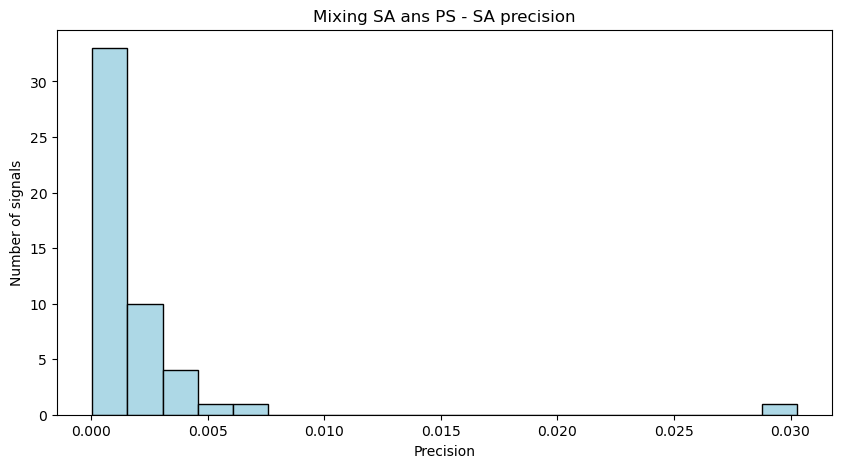

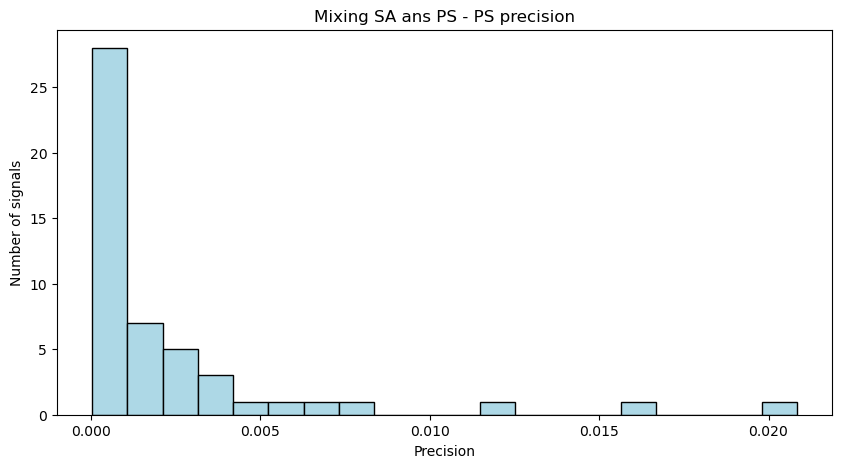

In [19]:
results1 = []
results2 = []

for i in tqdm(range(50)):

    w_SA = random.uniform(0, 0.1)
    w_PS = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SA=w_SA, w_PS=w_PS, w_SS=0, N=0, Num_beats=1000, mean_T=1, std_T=1)

    data = signal_to_data(sig)
                
    bds = [(1e-06, 0.5), (1e-06, 0.5)]
    init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5)]
    result = minimize(likelihood_SA_PS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_SA)
    results1.append(precision)
    precision = abs(result.x[1]-w_PS)
    results2.append(precision)

histogram_plot(results1, "Mixing SA ans PS - SA precision")
histogram_plot(results2, "Mixing SA ans PS - PS precision")
SA_mix1_results = results1
PS_mix1_results = results2

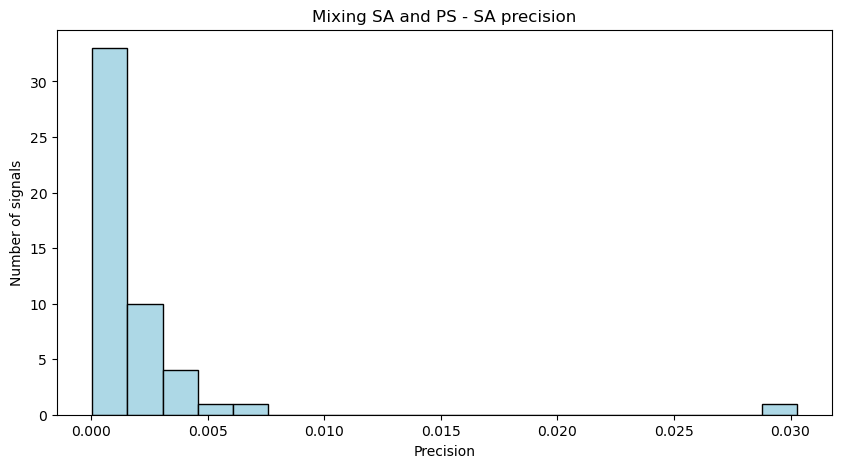

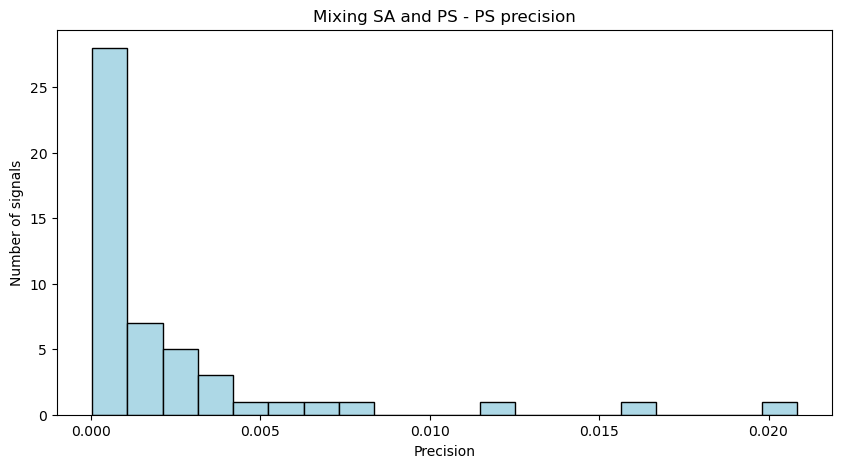

In [26]:
histogram_plot(SA_mix1_results, "Mixing SA and PS - SA precision")
histogram_plot(PS_mix1_results, "Mixing SA and PS - PS precision")

### Mixing SS and PS

In [20]:
def likelihood_PS_SS(params, x):
    """
    Compute the likelihood of a signal based on the value of w_PS and w_SS. 
    It is assumed that only I_PS and I_SS has impact on the interbeat at 
    time n in the Ivanov model

    Arguments:
    - params: the parameter value of w_PS and w_SS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    neg_log_likelihood = 0
    for el in x:
        is_unimodal_PS, mean_PS, std_PS, p_t_PS = PS_proba(el[1], w=params[0])
        mean_SS, std_SS = SS_proba_N(el[1], w=params[1])

        limit = get_limit(mean_SS, mean_PS, std_SS, std_PS, 1)

        precision = 0.0001
        x_tmp = np.arange(-limit, limit, precision)

        if is_unimodal_PS:
            pdf_PS = laplace.pdf(x_tmp, loc=mean_PS, scale=std_PS/math.sqrt(2))
        else:
            pdf_PS = p_t_PS*laplace.pdf(x_tmp, loc=-mean_PS, scale=std_PS/math.sqrt(2)) + (1-p_t_PS)*laplace.pdf(x_tmp, loc=mean_PS, scale=std_PS/math.sqrt(2))

        pdf_SS = norm.pdf(x_tmp, loc=mean_SS, scale=std_SS)
            
        pdf = signal.convolve(pdf_SS, pdf_PS, mode='same') * precision


        likelihood = np.interp(el[0], x_tmp, pdf)

        if likelihood<=0:
            likelihood = 1e-20
        
        neg_log_likelihood -= np.log(likelihood)

    return neg_log_likelihood


#### MLE one one trial

In [136]:
w_SA_s = np.linspace(0.02, 0.04, 15)
w_PS_s = np.linspace(0.02, 0.04, 15)

likelihoods = []

sig = fm.IvanovModel(w_SA=0, w_PS=0.03, w_SS=0.03, Num_beats=1000, N=1, t_PS_higher=1, t_PS_lower=0.2)

data = signal_to_data(sig)

for w_SA in tqdm(w_SA_s):
    tmp = []
    for w_PS in w_PS_s:

        params = [w_SA, w_PS]
        x = likelihood_PS_SS(params, data)
        tmp.append(x)

    likelihoods.append(tmp)


100%|██████████| 15/15 [03:06<00:00, 12.46s/it]


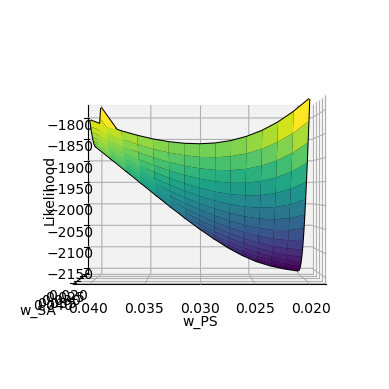

In [138]:
plot_3d(w_SA_s, w_PS_s, likelihoods, xlabel="w_PS", ylabel="w_SA", zlabel="Likelihood", angle1=0, angle2=90)

In [115]:
sig = fm.IvanovModel(w_SA=0, w_PS=0.01, w_SS=0.03, Num_beats=1000, mean_T = 1, std_T=1, std_eta=0.5*math.sqrt(2))

data = signal_to_data(sig)
                
bds = [(1e-06, 0.1), (1e-06, 0.1)]
init_params = [random.uniform(0, 0.1), random.uniform(0, 0.1)]
result = minimize(likelihood_PS_SS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
print(result.x)

[0.00995203 0.0282812 ]


#### MLE on several trials

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [10:52:11<00:00, 782.64s/it]


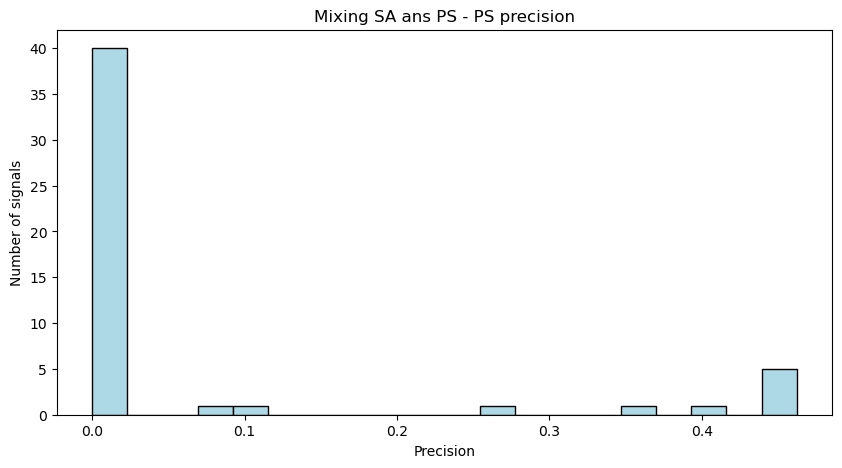

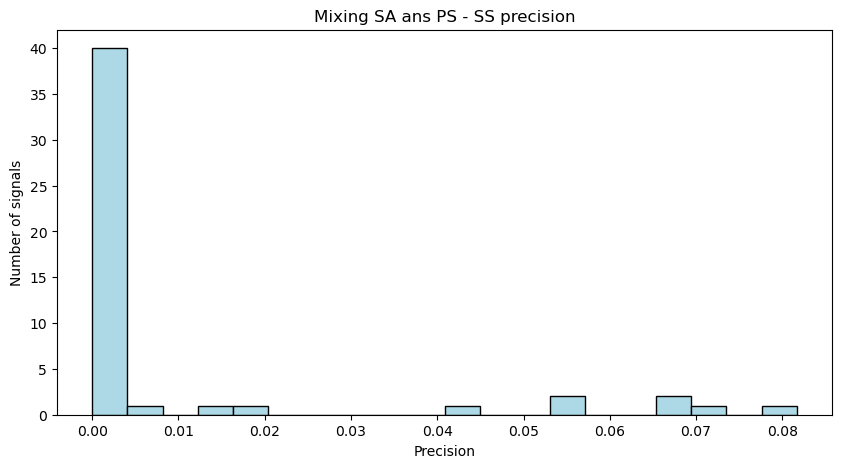

In [21]:
results1 = []
results2 = []

for i in tqdm(range(50)):

    w_SS = random.uniform(0, 0.1)
    w_PS = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SA=0, w_PS=w_PS, w_SS=w_SS, Num_beats=1000, mean_T = 1, std_T=1, std_eta=0.5*math.sqrt(2))

    data = signal_to_data(sig)
                
    bds = [(1e-06, 0.5), (1e-06, 0.5)]
    init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5)]
    result = minimize(likelihood_PS_SS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_PS)
    results1.append(precision)
    precision = abs(result.x[1]-w_SS)
    results2.append(precision)

histogram_plot(results1, "Mixing SA ans PS - PS precision")
histogram_plot(results2, "Mixing SA ans PS - SS precision")
PS_mix2_results = results1
SS_mix2_results = results2

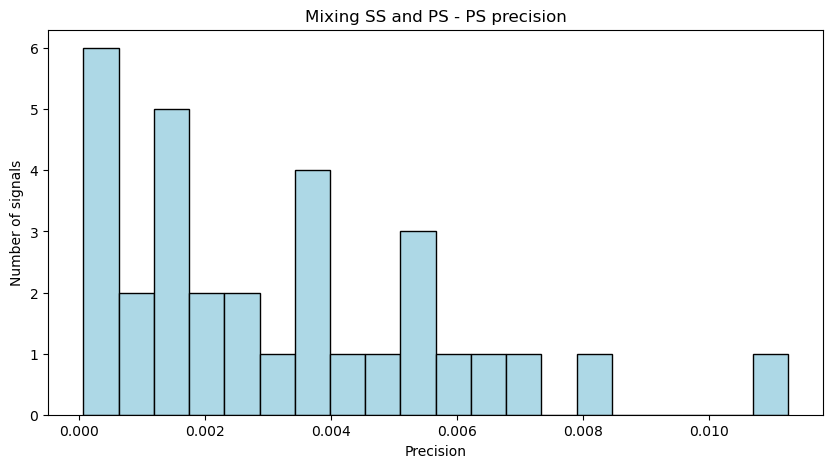

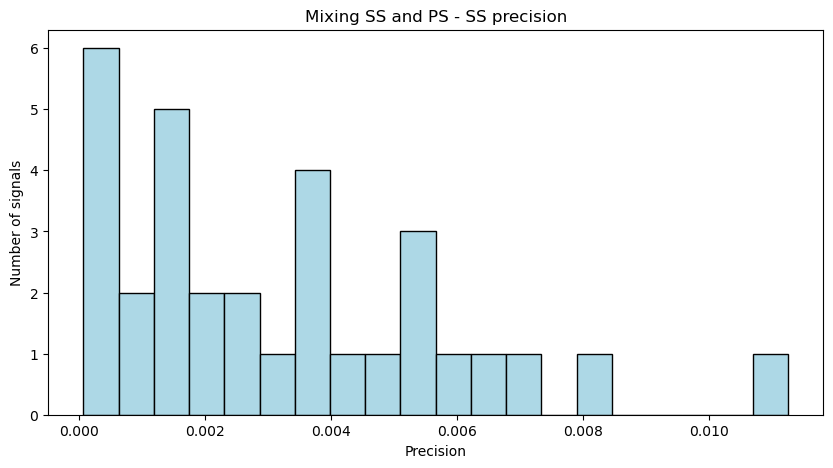

In [25]:
PS_mix2_results_test = [x for x in PS_mix2_results if x < 0.012]
SS_mix2_results_test = [x for x in PS_mix2_results if x < 0.012]
histogram_plot(PS_mix2_results_test, "Mixing SS and PS - PS precision")
histogram_plot(SS_mix2_results_test, "Mixing SS and PS - SS precision")

### Mixing SA and SS

In [22]:
def likelihood_SA_SS(params, x):
    """
    Compute the likelihood of a signal based on the value of w_SA and w_SS. 
    It is assumed that only I_SA and I_SS has impact on the interbeat at time 
    n in the Ivanov model

    Arguments:
    - params: the parameter value of w_SA and w_SS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    neg_log_likelihood = 0
    for el in x:
        mean_SA, std_SA = SA_proba(el[1], w_SA=params[0], std_eta=0.5*math.sqrt(2))
        mean_SS, std_SS = SS_proba_N(el[1], w=params[1], N=7, std_eta=0.5*math.sqrt(2))


        std = math.sqrt(std_SA**2 + std_SS**2)

        limit1 = min(mean_SA, mean_SS, mean_SS + mean_SA)
        limit2 = max(mean_SA, mean_SS, mean_SS + mean_SA)

        precision = 0.0001
        x_tmp = np.arange(limit1-3*std, limit2 + 3*std, precision)
        pdf_SA = laplace.pdf(x_tmp, loc=mean_SA, scale=std_SA/math.sqrt(2))
        pdf_SS = norm.pdf(x_tmp, loc=mean_SS, scale=std_SS)
        pdf = signal.convolve(pdf_SA, pdf_SS, mode='same') * precision

        likelihood = np.interp(el[0], x_tmp, pdf)

        if likelihood<=0:
            likelihood = 1e-20
        
        neg_log_likelihood -= np.log(likelihood)

    return neg_log_likelihood


#### MLE on one trial

In [133]:
w_SA_s = np.linspace(0.005, 0.1, 20)
w_PS_s = np.linspace(0.005, 0.1, 20)

likelihoods = []

sig = fm.IvanovModel(w_SA=0.01, w_PS=0, w_SS=0.02, Num_beats=1000, std_T=1, mean_T=1)

data = signal_to_data(sig)

for w_SA in tqdm(w_SA_s):
    tmp = []
    for w_PS in w_PS_s:

        params = [w_SA, w_PS]
        x = likelihood_SA_SS(params, data)
        tmp.append(x)

    likelihoods.append(tmp)


100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


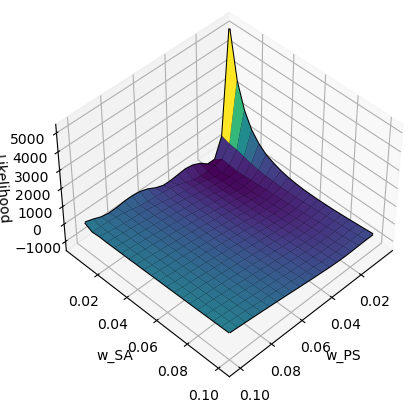

In [141]:
plot_3d(w_SA_s, w_PS_s, likelihoods, xlabel="w_PS", ylabel="w_SA", zlabel="Likelihood", angle1=45, angle2=45)

In [145]:
sig = fm.IvanovModel(w_SS=0.01, w_PS=0, w_SA=0.01, Num_beats=1000, std_T=1, mean_T=1, std_eta=0.5*math.sqrt(2))

data = signal_to_data(sig)
                
bds = [(1e-06, 0.5), (1e-06, 0.5)]
init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5)]
result = minimize(likelihood_SA_SS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
print(result.x)

[0.02274328 0.0086796 ]


#### MLE on several trials

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [10:33:46<00:00, 760.52s/it]


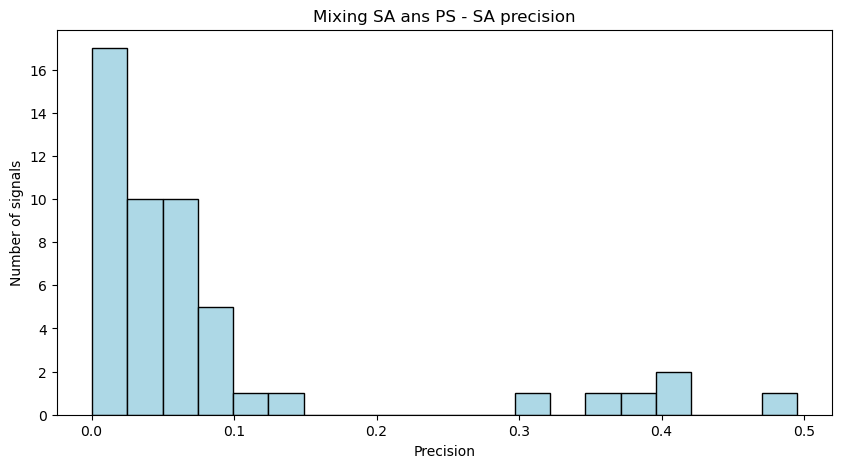

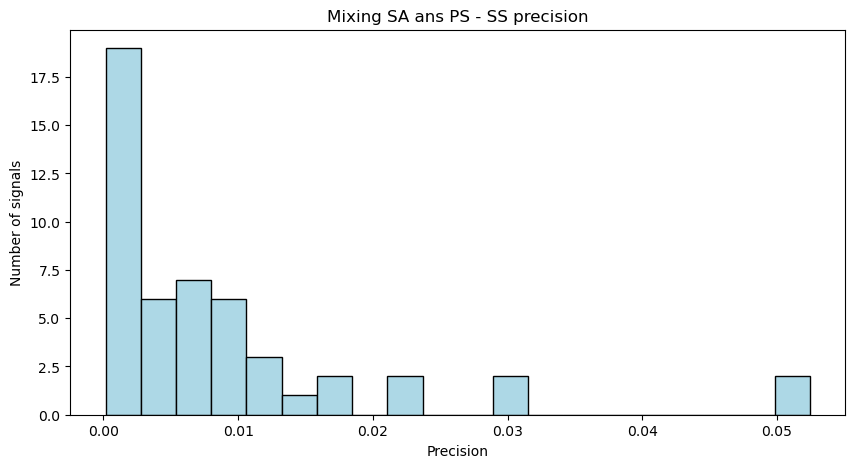

In [23]:
results1 = []
results2 = []

for i in tqdm(range(50)):

    w_SS = random.uniform(0, 0.1)
    w_SA = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SA=w_SA, w_PS=0, w_SS=w_SS, Num_beats=1000, mean_T = 1, std_T=1, std_eta=0.5*math.sqrt(2))

    data = signal_to_data(sig)
                
    bds = [(1e-06, 0.5), (1e-06, 0.5)]
    init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5)]
    result = minimize(likelihood_PS_SS, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_SA)
    results1.append(precision)
    precision = abs(result.x[1]-w_SS)
    results2.append(precision)

histogram_plot(results1, "Mixing SA and PS - SA precision")
histogram_plot(results2, "Mixing SA and PS - SS precision")
mix3_SA = results1
mix3_SS = results2

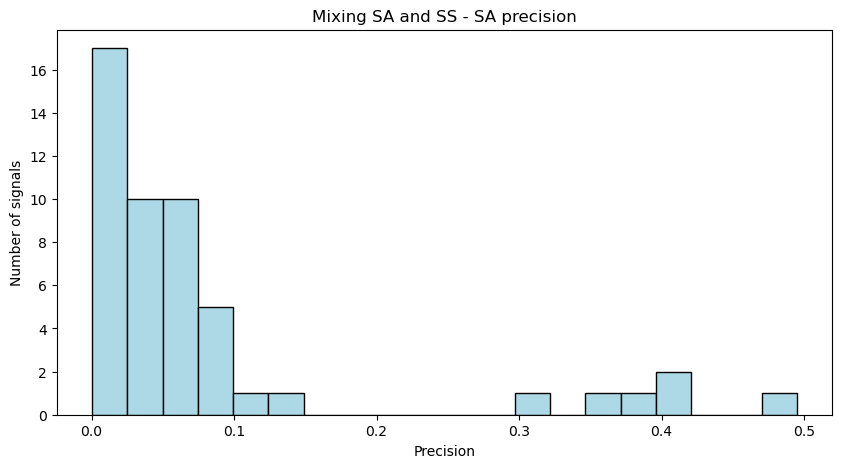

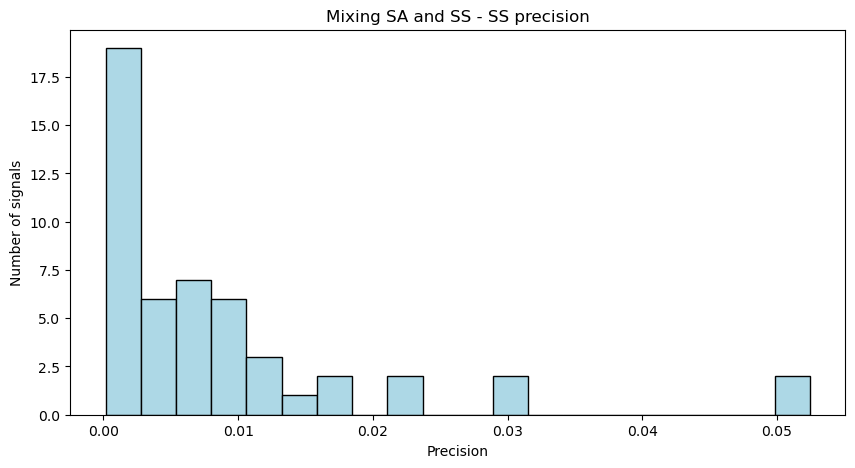

In [28]:
histogram_plot(results1, "Mixing SA and SS - SA precision")
histogram_plot(results2, "Mixing SA and SS - SS precision")
mix3_SA = results1
mix3_SS = results2

## Maximum likelihood estimation with three feedback inputs

In [30]:
def likelihood_all(params, x):
    """
    Compute the likelihood of a signal based on the value of w_SA, w_PS and 
    w_SS.

    Arguments:
    - params: the parameter value of w_SA, w_PS and w_SS
    - x: the observed data. This data is the signal transformed with the method
            signal_to_data

    Returns:
    - the negative log likelihood
    """
    neg_log_likelihood = 0
    for el in x:
        mean_SA, std_SA = SA_proba(el[1], w_SA=params[0], std_eta=0.5 * math.sqrt(2))
        is_unimodal, mean_PS, std_PS, p_t = PS_proba(el[1], w=params[1], std_eta=0.5 * math.sqrt(2))
        mean_SS, std_SS = SS_proba_N(el[1], w=params[2], N=7, std_eta=0.5*math.sqrt(2))

        std = math.sqrt(std_PS**2 + std_SA**2 + std_PS**2)
        limit1 = min(mean_SA, mean_PS, mean_SS, mean_SS + mean_SA + mean_PS)
        limit2 = max(mean_SA, mean_PS, mean_SS, mean_SS + mean_SA + mean_PS)

        precision = 0.0001
        x_tmp = np.arange(limit1 - 3*std, limit2 + 3*std, precision)

        if is_unimodal:
            mean = mean_SA + mean_PS
            std = math.sqrt(std_SA**2 + std_PS**2)
            pdf_SA_PS = laplace.pdf(x_tmp, loc=mean, scale=std/math.sqrt(2))

        else:

            pdf_SA = laplace.pdf(x_tmp, loc=mean_SA, scale=std_SA/math.sqrt(2))
            pdf_PS = p_t*laplace.pdf(x_tmp, loc=-mean_PS, scale=std_PS/math.sqrt(2)) + (1-p_t)*laplace.pdf(x_tmp, loc=mean_PS, scale=std_PS/math.sqrt(2))
            pdf_SA_PS = signal.convolve(pdf_SA, pdf_PS, mode='same') * precision

        pdf_SS = norm.pdf(x_tmp, loc=mean_SS, scale=std_SS)
        pdf = signal.convolve(pdf_SA_PS, pdf_SS, mode='same') * precision

        likelihood = np.interp(el[0], x_tmp, pdf)

        if likelihood<=0:
            likelihood = 1e-20
        
        neg_log_likelihood -= np.log(likelihood)

    #print(neg_log_likelihood, params)
    return neg_log_likelihood


### MLE on one trial

In [ ]:
sig = fm.IvanovModel(w_SS=0.01, w_PS=0.03, w_SA=0.01, Num_beats=1000, std_T=1, mean_T=1, std_eta=0.5*math.sqrt(2))

data = signal_to_data(sig)
                
bds = [(1e-06, 0.5), (1e-06, 0.5), (1e-06, 0.5)]
init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5), random.uniform(0, 0.5)]
result = minimize(likelihood_all, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
print(result.x)

### MLE on several trials

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [8:46:24<00:00, 631.68s/it]


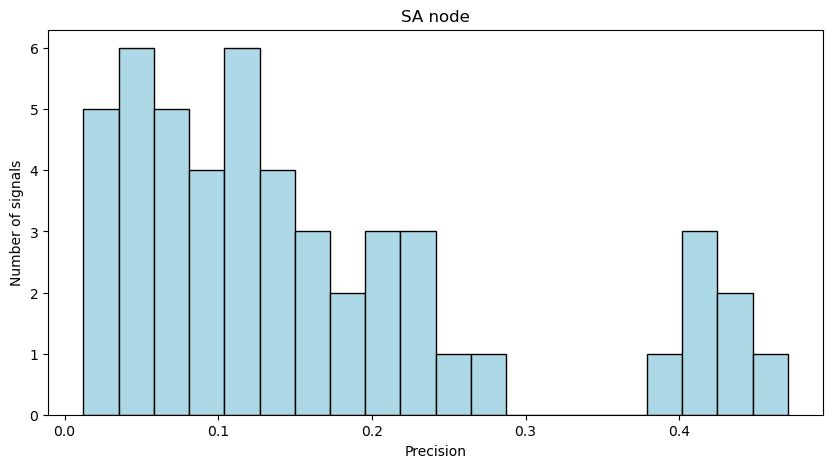

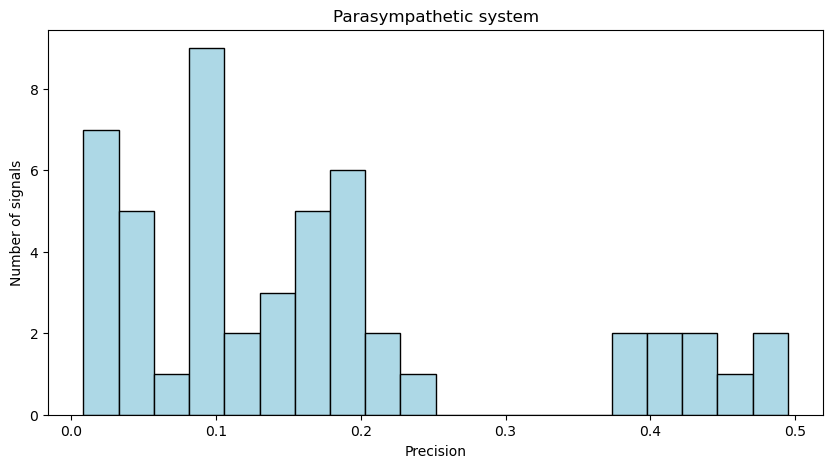

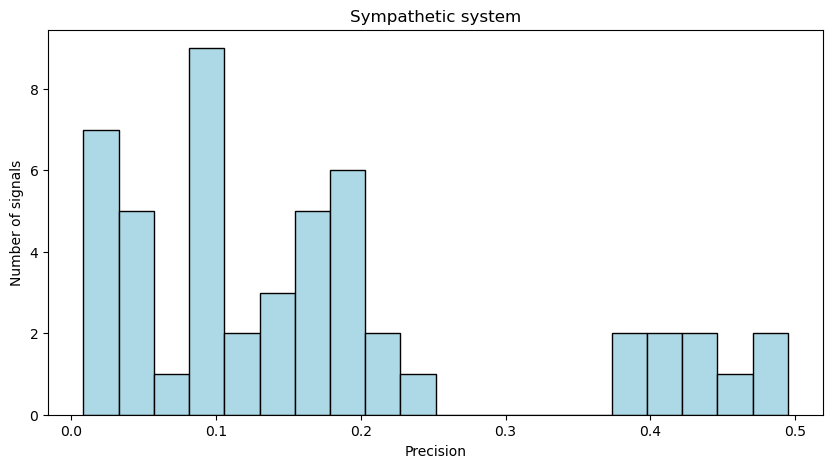

In [33]:
results1 = []
results2 = []
results3 = []


for i in tqdm(range(50)):

    w_SS = random.uniform(0, 0.1)
    w_SA = random.uniform(0, 0.1)
    w_PS = random.uniform(0, 0.1)
    sig = fm.IvanovModel(w_SA=w_SA, w_PS=w_PS, w_SS=w_SS, Num_beats=1000, mean_T = 1, std_T=1, std_eta=0.5*math.sqrt(2))

    data = signal_to_data(sig)
                
    bds = [(1e-06, 0.5), (1e-06, 0.5), (1e-06, 0.5)]
    init_params = [random.uniform(0, 0.5), random.uniform(0, 0.5), random.uniform(0, 0.5)]
    result = minimize(likelihood_all, init_params, args=(data,), bounds = bds, options={'maxiter': 50}, method='Nelder-Mead') #, method='L-BFGS-B', bounds = bds) # method ='SLSQP',
    precision = abs(result.x[0]-w_SA)
    results1.append(precision)
    precision = abs(result.x[1]-w_PS)
    results2.append(precision)
    precision = abs(result.x[2]-w_SS)
    results3.append(precision)

histogram_plot(results1, "SA node")
histogram_plot(results2, "Parasympathetic system")
histogram_plot(results2, "Sympathetic system")